## Face and Facial Keypoint detection

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

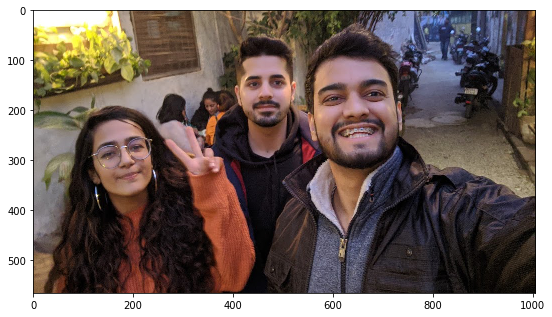

In [3]:
import cv2
# load in color image for face detection
image = cv2.imread('images/my friends.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, I will use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original).

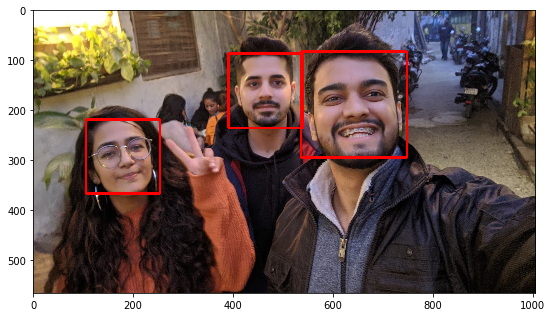

In [5]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
faces = face_cascade.detectMultiScale(image, 1.2, 4)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # drawing a rectangle around each detected face
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

In [6]:
import torch
from models import Net

net = Net()

net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
)

## Keypoint detection

I will have to loop over each detected face in an image again, and transform those faces in Tensors that my CNN can accept as input images.

I will apply the following steps on the image:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

### Detect and display the predicted keypoints

After each face has been converted into an input Tensor we can apply the `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display.

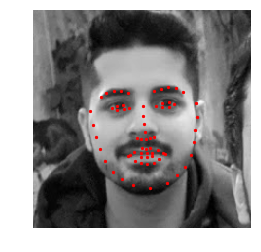

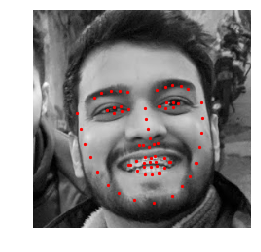

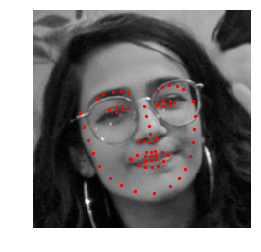

In [7]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-30:y+h+30, x-30:x+w+30]
    
    # Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    # Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    roi_copy = np.copy(roi)
    # adding gray channel
    roi = roi.reshape(224, 224, 1)
    # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = torch.Tensor(roi.transpose(2, 0, 1))
    roi = roi.unsqueeze(0)
    # Make facial keypoint predictions using your loaded, trained network 
    with torch.no_grad():
        key_pts = net(roi)
    key_pts = key_pts.view(key_pts.size()[0], 68, -1)[0].data.numpy()
    # print(key_pts.shape)
    # un-normalize the key points
    key_pts = key_pts*50.0+100
    # Display each detected face and the corresponding keypoints        
    plt.imshow(roi_copy, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='r')
    plt.axis('off')
    plt.show()
        

That's all folks!